In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

input_dir = "out01_robustreg_behav_hc3_stdz_age_reverse_fa"
output_dir = "out02_robustreg_behav_hc3_stdz_age_reverse_fa"

# rsquare_thresh = .09
rsquare_thresh = -1



coefs_data = pd.read_csv(input_dir+'/out01_behav_feature_beta_ransac_lr.csv')
coefs_data = coefs_data.loc[coefs_data['modality']!='behav',:]
coefs_data['thresh'] = True

coefs_data.loc[coefs_data['Rsquare']<rsquare_thresh, 'thresh'] = False
coefs_data.loc[coefs_data['Rsquare']>=rsquare_thresh, 'thresh'] = True

coefs_data.columns.values[0] = 'feature'

In [2]:
coefs_data

,feature,modality,age,age$^2$,gender,age*gender,age$^2$*gender,Rsquare,thresh
26,Left Precentral,gmv,-0.439251,0.044466,0.120020,-0.030640,0.023704,0.406745,True
27,Right Precentral,gmv,-0.358630,0.067951,0.078408,-0.106059,0.019583,0.273327,True
28,Left Superior Frontal,gmv,-0.398763,0.052602,0.205523,0.015236,-0.101581,0.371393,True
29,Right Superior Frontal,gmv,-0.260466,0.026848,0.145865,-0.027831,-0.027371,0.166018,True
30,Left Superior Frontal Orbital,gmv,-0.454677,0.172454,-0.033681,-0.044744,0.015875,0.381207,True
...,...,...,...,...,...,...,...,...,...
207,Superior.longitudinal.fasciculus.R(tract),tract_fa,-0.313694,0.128628,-0.087989,-0.041649,-0.034377,0.243658,True
208,Uncinate.fasciculus.L(tract),tract_fa,-0.224377,0.197591,0.059521,-0.052759,-0.126983,0.168414,True
209,Uncinate.fasciculus.R(tract),tract_fa,-0.233882,0.185072,-0.012746,-0.088522,-0.062842,0.194901,True
210,Superior.longitudinal.fasciculus.(temporal.pa...,tract_fa,-0.144291,0.107165,-0.003090,0.014678,-0.022324,0.025660,True


In [3]:
print(coefs_data.shape)

(186, 9)


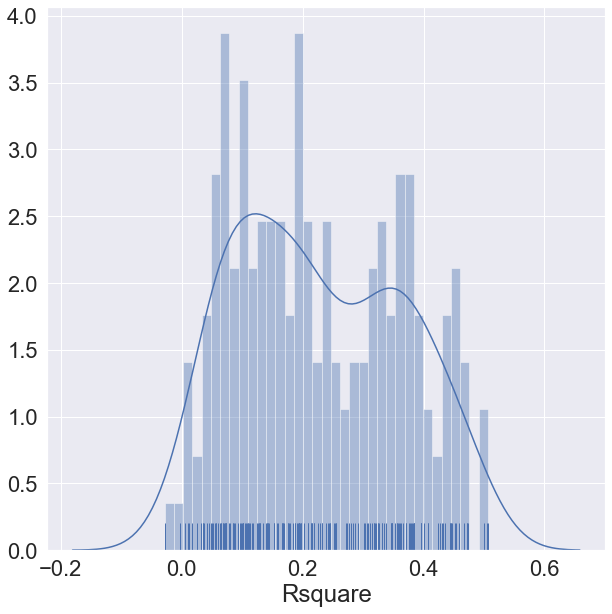

In [4]:
sns.set(rc={'figure.figsize':(10, 10)}, font_scale = 2)
sns.distplot(coefs_data['Rsquare'], bins = 35, rug = True)

In [5]:

# from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

sns.set(rc={'figure.figsize':(10, 10)}, font_scale = 2)


# columns = ['beta1', 'beta2', 'beta4', 'beta5', 'peak_age_f', 'peak_age_m']
# columns = ['beta1', 'beta2', 'beta3', 'beta4', 'beta5']
columns = ['age', 'age$^2$', 'gender', 'age*gender', 'age$^2$*gender']

X_varied = coefs_data.loc[coefs_data['thresh']==True, columns]

# scaler = RobustScaler()
scaler = MinMaxScaler()
scaler.fit(X_varied)
X_scale = scaler.transform(X_varied)
# X_varied = preprocessing.scale(X_varied)

print(X_varied.mean(axis = 0))
print(X_varied.std(axis = 0))

print(X_scale.mean(axis = 0))
print(X_scale.std(axis = 0))

# plt.figure()
# plt.plot(X_scale[:,0], X_scale[:,1], '*')




age              -0.292417
age$^2$           0.083744
gender            0.034163
age*gender       -0.012975
age$^2$*gender   -0.026337
dtype: float64
age               0.136109
age$^2$           0.068820
gender            0.091975
age*gender        0.069536
age$^2$*gender    0.063377
dtype: float64
[0.43477761 0.43557619 0.37573122 0.51152962 0.56411695]
[0.18243333 0.1480259  0.16224577 0.19270237 0.17565889]


In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics

Sum_of_squared_distances = []
sils_euclidean=[]
sils_manhattan=[]
K = range(2,10)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_scale)
    Sum_of_squared_distances.append(km.inertia_)
    
    labels = km.predict(X_scale)
    sil_euc=metrics.silhouette_score(X_scale, labels, metric='euclidean')
    sil_man=metrics.silhouette_score(X_scale, labels, metric='manhattan')
    
    sils_euclidean.append(sil_euc)    
    sils_manhattan.append(sil_man)    



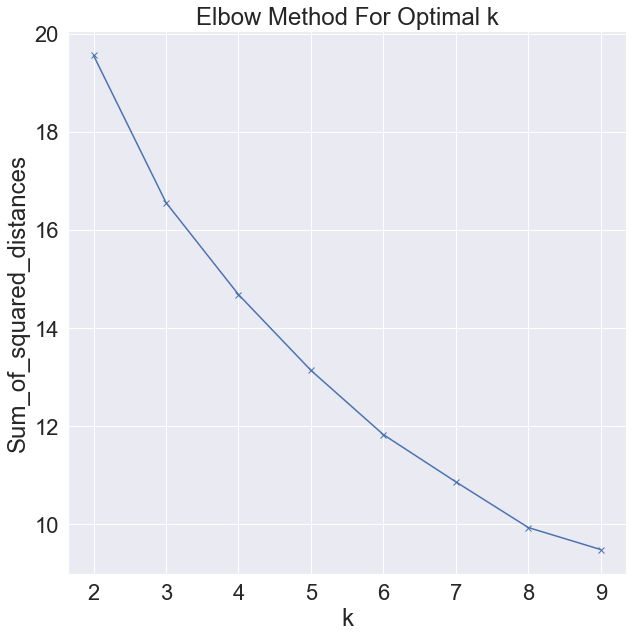

In [7]:
 
plt.plot(K, Sum_of_squared_distances, 'bx-') 
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


Text(0, 0.5, 'Score')

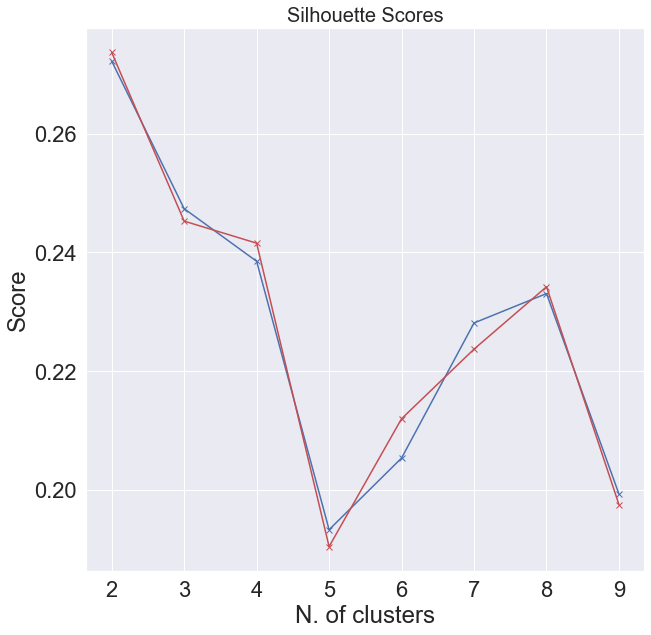

In [9]:

plt.plot(K, sils_euclidean, 'bx-')
plt.plot(K, sils_manhattan, 'rx-')
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(K)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [10]:
# cluster_k = 5
# y_pred = KMeans(n_clusters=cluster_k, random_state=111).fit_predict(X_scale)
# coefs_data.loc[coefs_data['cluster']>0, 'cluster'] = y_pred+1
# coefs_data_raw.loc[coefs_data_raw['cluster']>0, 'cluster'] = y_pred+1


In [11]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]


#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. 
#Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)


n_clusters=np.arange(2, 7)

sils=[]
sils_err=[]

bics=[]
bics_err=[]

js_dist=[]
js_err=[]

iterations=20
for n in n_clusters:
    print(n)
    
    tmp_sil=[]
    tmp_bic=[]
    tmp_dist=[]
    
    for itr in range(iterations):
        #print(itr)
        
        gmm=GMM(n, n_init=20).fit(X_scale) 
        labels=gmm.predict(X_scale)
        sil=metrics.silhouette_score(X_scale, labels, metric='manhattan')
        tmp_sil.append(sil)
        tmp_bic.append(gmm.bic(X_scale))
        
        train, test=train_test_split(X_scale, test_size=0.5)
        
        gmm_train=GMM(n, n_init=20).fit(train) 
        gmm_test=GMM(n, n_init=20).fit(test) 
        tmp_dist.append(gmm_js(gmm_train, gmm_test))
        
    val=np.mean(SelBest(np.array(tmp_dist), int(iterations/5)))
    err=np.std(tmp_dist)
    js_dist.append(val)
    js_err.append(err)
        
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)
    
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)
    

2
3
4
5
6


Text(0, 0.5, 'Score')

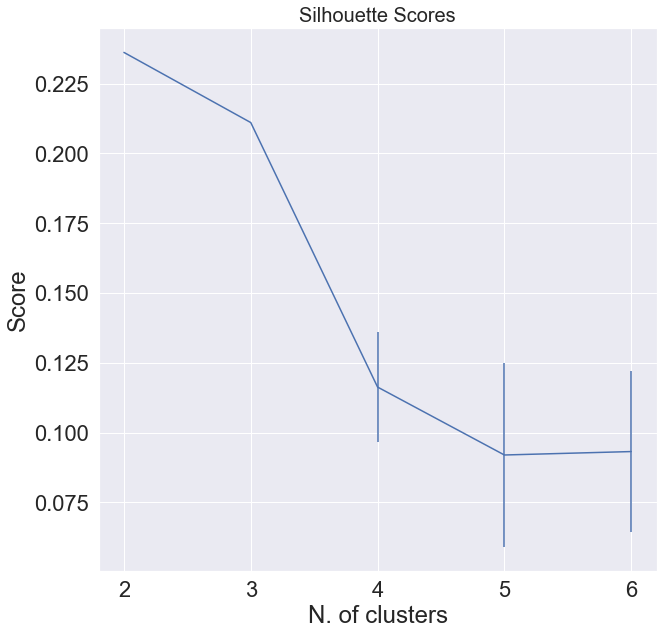

In [12]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

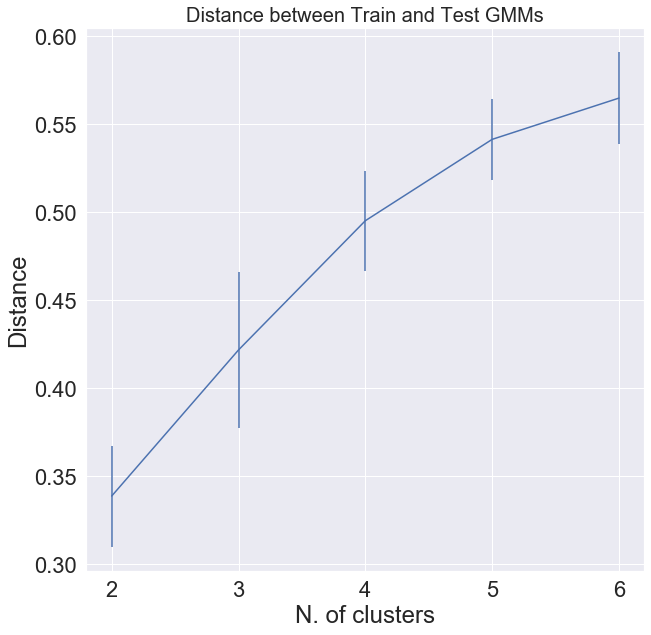

In [13]:

plt.errorbar(n_clusters, js_dist, yerr=js_err)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

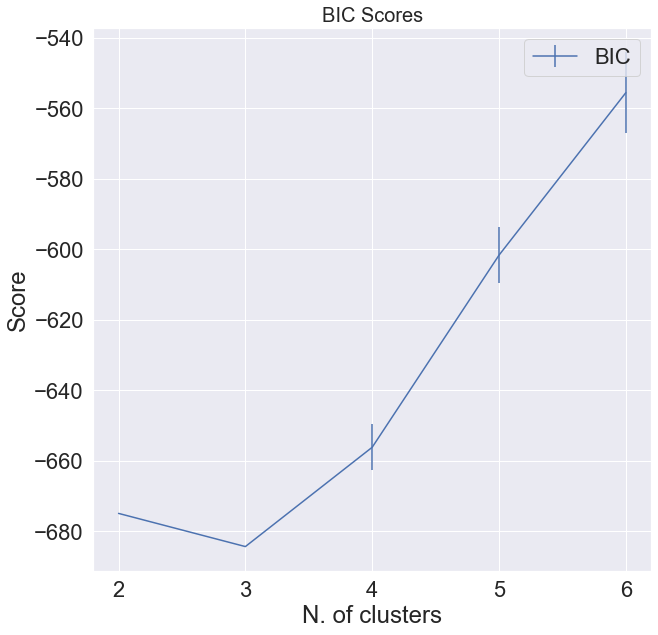

In [14]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

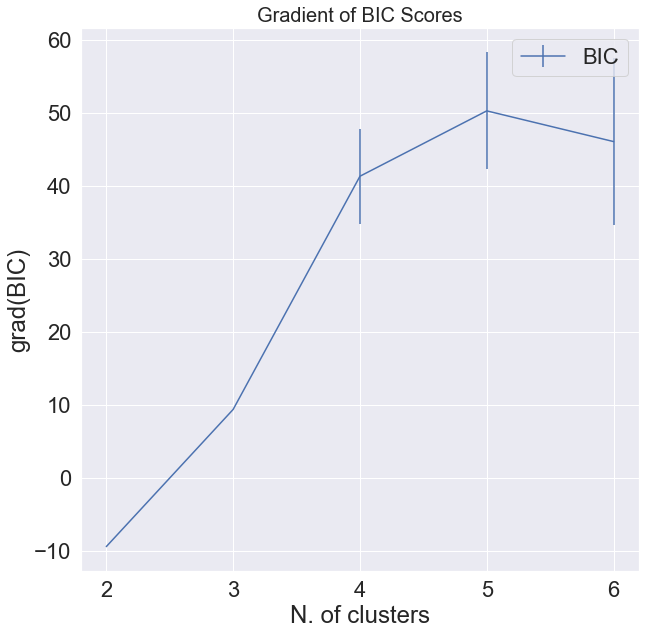

In [15]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [16]:


from sklearn.metrics.cluster import contingency_matrix

def align_cluster_index(ref_cluster, map_cluster):
    """
    remap cluster index according the the ref_cluster.
    both inputs must have same number of unique cluster index values.
    """
    
    ref_values = np.unique(ref_cluster)
    map_values = np.unique(map_cluster)
    
    if ref_values.shape[0]!=map_values.shape[0]:
        print('error: both inputs must have same number of unique cluster index values.')
        return()
    
    cont_mat = contingency_matrix(ref_cluster, map_cluster)
    num_rows = len(cont_mat)
    
    cont_mat_col_sum = np.matmul(np.ones((num_rows, 1)), np.sum(cont_mat, axis = 0).reshape(1, num_rows))
    cont_mat_row_sum = np.matmul(np.sum(cont_mat, axis = 1).reshape(num_rows, 1), np.ones((1, num_rows)))
    cont_mat = cont_mat*2/(cont_mat_col_sum + cont_mat_row_sum)
    print(cont_mat)
    
    sort_0 = np.argsort(cont_mat, axis = 0)
    sort_1 = np.argsort(cont_mat, axis = 1)
    
    for i_row in range(len(cont_mat)):
        # switch values:
        cluster_tmp = map_cluster
        map_cluster[cluster_tmp==map_values[sort_1[i_row,-1]]]=ref_values[i_row]
        map_cluster[cluster_tmp==map_values[i_row]]=ref_values[sort_1[i_row,-1]]
            
    
    return(map_cluster)
    

In [26]:

np.set_printoptions(threshold=1000)
cluster_k = 3

############# K means #####################

km = KMeans(n_clusters=cluster_k, n_init=20)
km = km.fit(X_scale)
km_cluster = km.predict(X_scale)


############# GMM #########################


repetition = 5
y_pred = np.zeros((X_scale.shape[0], repetition))+1111

for i in range(repetition):

    dpgmm = GMM(n_components=cluster_k, n_init = 5000, covariance_type='full', random_state = i).fit(X_scale)
    y_pred[:, i] = dpgmm.predict(X_scale)

print(y_pred)

for i in range(1, repetition):
    y_pred_i = align_cluster_index(y_pred[:,0], y_pred[:,i])
    y_pred[:,i]=y_pred_i
    
print(y_pred)

cluster_gmm = np.zeros(X_scale.shape[0])+110
for ik in range(cluster_k):
    ik_count = np.sum(y_pred==ik, axis = 1)
#     print(ik_count)
    cluster_gmm[ik_count>=7]=ik
    
cluster_gmm=y_pred[:,0]
    

[[0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [2. 2. 0. 0. 2.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [2. 2. 0. 0. 2.]
 [2. 2. 0. 0. 2.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [1. 0. 1. 1. 1.]
 [2. 2. 1. 1. 2.]
 [2. 2. 0. 0. 2.]
 [2. 2. 0. 0. 2.]
 [2. 2. 0. 0. 2.]
 [2. 2. 1. 1. 2.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2. 2. 0.]
 [0. 1. 2.

In [27]:
coefs_data.loc[coefs_data['thresh']==True, 'cluster_km'] = km_cluster+1
coefs_data.loc[coefs_data['thresh']==True, 'cluster_gmm'] = cluster_gmm+1


In [28]:
coefs_summary = coefs_data.groupby('cluster_gmm').mean()
print(coefs_summary.columns)
coefs_summary

Index(['age', 'age$^2$', 'gender', 'age*gender', 'age$^2$*gender', 'Rsquare',
       'thresh', 'cluster_km'],
      dtype='object')


,age,age$^2$,gender,age*gender,age$^2$*gender,Rsquare,thresh,cluster_km
cluster_gmm,,,,,,,,
1.0,-0.398728,0.090735,0.069940,-0.041082,0.016285,0.337101,True,1.120482
2.0,-0.233770,0.127231,0.015273,0.019705,-0.077358,0.159265,True,2.070175
3.0,-0.173267,0.017245,-0.006986,-0.002756,-0.040021,0.112510,True,2.239130


In [29]:
coefs_data.to_csv(output_dir+'/out02_coefs_cluster_sklearn.csv')
coefs_data

,feature,modality,age,age$^2$,gender,age*gender,age$^2$*gender,Rsquare,thresh,cluster_km,cluster_gmm
26,Left Precentral,gmv,-0.439251,0.044466,0.120020,-0.030640,0.023704,0.406745,True,1,1.0
27,Right Precentral,gmv,-0.358630,0.067951,0.078408,-0.106059,0.019583,0.273327,True,1,1.0
28,Left Superior Frontal,gmv,-0.398763,0.052602,0.205523,0.015236,-0.101581,0.371393,True,2,1.0
29,Right Superior Frontal,gmv,-0.260466,0.026848,0.145865,-0.027831,-0.027371,0.166018,True,1,1.0
30,Left Superior Frontal Orbital,gmv,-0.454677,0.172454,-0.033681,-0.044744,0.015875,0.381207,True,1,1.0
31,Right Superior Frontal Orbital,gmv,-0.408525,0.074470,0.032014,-0.077486,0.005029,0.331671,True,1,1.0
32,Left Middle Frontal,gmv,-0.452051,0.077712,0.153355,-0.035486,-0.011385,0.504345,True,1,1.0
33,Right Middle Frontal,gmv,-0.482412,0.107859,0.109747,-0.054190,-0.003558,0.443295,True,1,1.0
34,Left Middle Frontal Orbital,gmv,-0.444710,0.139076,-0.009524,-0.060057,0.045189,0.472629,True,1,1.0
35,Right Middle Frontal Orbital,gmv,-0.446806,0.116217,0.043776,-0.036998,0.026046,0.400295,True,1,1.0


In [30]:
pd.set_option('display.max_rows', 500)
print(coefs_data.loc[coefs_data['cluster_gmm']==1,:].shape)
coefs_data.loc[coefs_data['cluster_gmm']==1,:].sort_values(by='Rsquare', ascending=False)


(83, 11)


,feature,modality,age,age$^2$,gender,age*gender,age$^2$*gender,Rsquare,thresh,cluster_km,cluster_gmm
107,Right Superior Temporal,gmv,-0.513646,0.181904,0.107376,-0.059276,-0.005384,0.506176,True,1,1.0
32,Left Middle Frontal,gmv,-0.452051,0.077712,0.153355,-0.035486,-0.011385,0.504345,True,1,1.0
38,Left Inferior Frontal,gmv,-0.487502,0.085710,0.044646,-0.080341,0.013531,0.499611,True,1,1.0
101,Right Pallidum,gmv,-0.615920,0.345447,-0.079339,-0.121034,0.076979,0.473340,True,1,1.0
34,Left Middle Frontal Orbital,gmv,-0.444710,0.139076,-0.009524,-0.060057,0.045189,0.472629,True,1,1.0
93,Right Precuneus,gmv,-0.493141,0.177190,0.157803,-0.035479,0.069585,0.471528,True,1,1.0
106,Left Superior Temporal,gmv,-0.466913,0.085996,0.160298,-0.023165,0.006040,0.466546,True,1,1.0
102,Left Thalamus,gmv,-0.424730,0.128444,0.020797,-0.048832,-0.009155,0.458909,True,1,1.0
111,Right Middle Temporal,gmv,-0.431225,0.144320,0.158762,-0.061622,0.028725,0.453308,True,1,1.0
41,Right Inferior Frontal Orbital,gmv,-0.489861,0.105863,0.000645,-0.017788,-0.001197,0.451806,True,1,1.0


In [31]:
print(coefs_data.loc[coefs_data['cluster_gmm']==2,:].shape)
coefs_data.loc[coefs_data['cluster_gmm']==2,:].sort_values(by='Rsquare', ascending=False)

(57, 11)


,feature,modality,age,age$^2$,gender,age*gender,age$^2$*gender,Rsquare,thresh,cluster_km,cluster_gmm
177,Cingulum.(cingulate.gyrus).L(label),label_fa,-0.398733,0.176754,-0.035237,-0.014895,-0.065522,0.366556,True,2,2.0
196,Cingulum.(cingulate.gyrus).L(tract),tract_fa,-0.375055,0.132329,-0.013584,0.016853,-0.081903,0.362916,True,2,2.0
176,Cingulum.(cingulate.gyrus).R(label),label_fa,-0.401860,0.142938,0.005578,0.041303,-0.077670,0.360634,True,2,2.0
197,Cingulum.(cingulate.gyrus).R(tract),tract_fa,-0.371423,0.129267,0.015852,0.052264,-0.107688,0.348084,True,2,2.0
158,Anterior.limb.of.internal.capsule.R(label),label_fa,-0.373032,0.172076,-0.081723,0.027435,-0.063880,0.330948,True,2,2.0
159,Anterior.limb.of.internal.capsule.L(label),label_fa,-0.336239,0.137017,-0.058690,-0.005411,-0.063651,0.307595,True,2,2.0
144,Genu.of.corpus.callosum(label),label_fa,-0.339325,0.130859,0.008653,0.079277,-0.083082,0.245331,True,2,2.0
207,Superior.longitudinal.fasciculus.R(tract),tract_fa,-0.313694,0.128628,-0.087989,-0.041649,-0.034377,0.243658,True,2,2.0
192,Anterior.thalamic.radiation.L(tract),tract_fa,-0.282534,0.130717,-0.074121,0.055398,-0.042909,0.242483,True,2,2.0
193,Anterior.thalamic.radiation.R(tract),tract_fa,-0.328854,0.138321,-0.061035,0.067732,-0.029753,0.238304,True,2,2.0


In [32]:
pd.set_option('display.max_rows', 500)
print(coefs_data.loc[coefs_data['cluster_gmm']==3,:].shape)
coefs_data.loc[coefs_data['cluster_gmm']==3,:].sort_values(by='Rsquare', ascending=False)

(46, 11)


,feature,modality,age,age$^2$,gender,age*gender,age$^2$*gender,Rsquare,thresh,cluster_km,cluster_gmm
138,Vermis_7,gmv,-0.457433,0.068517,0.000533,-0.151965,-0.022897,0.347116,True,1,3.0
119,Cerebellum_Crus2_R,gmv,-0.398119,0.051815,-0.025195,-0.179790,-0.099762,0.302724,True,1,3.0
53,Right Rectus,gmv,-0.380070,0.091053,-0.058142,-0.167409,0.047890,0.271305,True,1,3.0
117,Cerebellum_Crus1_R,gmv,-0.356473,-0.023369,0.010589,-0.181276,-0.070918,0.251819,True,1,3.0
127,Cerebellum_7b_R,gmv,-0.298225,0.056130,-0.021616,-0.129263,-0.076199,0.225305,True,1,3.0
116,Cerebellum_Crus1_L,gmv,-0.335850,-0.049472,0.016859,-0.197063,-0.110588,0.214628,True,1,3.0
174,External.capsule.R(label),label_fa,-0.283969,0.144677,-0.175034,-0.016567,-0.042596,0.202823,True,2,3.0
118,Cerebellum_Crus2_L,gmv,-0.256166,0.006212,-0.090221,-0.138280,-0.056094,0.197234,True,1,3.0
126,Cerebellum_7b_L,gmv,-0.291482,0.049877,-0.010435,-0.163475,-0.053320,0.195527,True,1,3.0
175,External.capsule.L(label),label_fa,-0.282924,0.118914,-0.178260,-0.055573,-0.022936,0.193737,True,2,3.0


In [33]:
print(coefs_data.loc[coefs_data['cluster']==4,:].shape)
coefs_data.loc[coefs_data['cluster']==4,:].sort_values(by='Rsquare', ascending=False)

KeyError: 'cluster'

In [ ]:
print(coefs_data.loc[coefs_data['cluster']==5,:].shape)
coefs_data.loc[coefs_data['cluster']==5,:].sort_values(by='Rsquare', ascending=False)

In [ ]:
# print(coefs_data.loc[coefs_data['cluster']==6,:].shape)
# coefs_data.loc[coefs_data['cluster']==6,:].sort_values(by='Rsquare', ascending=False)